<a href="https://colab.research.google.com/github/AlirezaPNouri/Papers/blob/main/Evolving_metric_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, we want to calculate the parameters for evoling metrics. what is the thereshold for two documents to consider match documents, which doesn't allow a story to be evolved

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# needed packages
import requests
import numpy as np
import pandas as pd
import string
import pickle
import os
from numpy import median, array, exp
from sklearn.cluster import KMeans
import copy
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm

In [3]:
#### Load the pre-traiend BERT model #####################
##########################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
#constant variables
dataset_covid_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_covid_data.csv'
dataset_NYT_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_NYT_data.csv'
dataset_percentage = .6
MAX_DATA = 100
MAX_SENTENCE_LENGTH = 350
MIN_SENTENCE_LENGTH = 200
doc_list =[item for item in range(MAX_DATA)]
jump = 3 # jump size for gradient decent
MAX_FEATURE_SIZE = 20 # max size of the gradient descent vector
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
threshold_cluster_overlapping = 0.7 # to consider two clsuters are similar
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']


In [5]:
# download the dataset as a zip file from the git repo
def dataset_downloader(str_):
  """
  This function download a dataset
  Arguments:
    str_: the name of the dataset. It can be covid or NYT
  Returns:
    df: a pandas dataframe
  """
  if str_ == 'covid':
    url = dataset_NYT_link
  elif str_ == 'NYT':
    url = dataset_covid_link
  else:
    print('dataset is not choose correctly!')

  print('Downloading dataset...')
  res = requests.get(url, allow_redirects=True)
  with open('small_dataset_NYT.csv','wb') as file:
      file.write(res.content)
  print('Download is done!')
  df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1)
  if str_ == 'NYT':
    df.columns = ['id', 'title', 'content', 'publish_time', 'author']
  elif str_ == 'covid':
    df.columns = ['id', 'title', 'content', 'author', 'publish_time']
  
  df = df.dropna(how='any', axis=0)
  print('dataset size after removing non-value cells is {}'.format(df.shape))
  # reduce the size of dataset to dataset_percentage*dataset.shape
  df = df.sample(frac=dataset_percentage)
  print('The new size of dataset is {} and the columns are {}'.format(df.shape, df.columns.values ))
  # remove the content that has less than MIN_SENTENCE_LENGTH words 
  df = df[df['content'].apply(lambda x : len(x.split(' ')))>=MIN_SENTENCE_LENGTH]

  # keep the first 500 words in content
  df['content'] = df['content'].apply(lambda x : ' '.join(x.split(' ')[:MAX_SENTENCE_LENGTH]))
  return df


In [6]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [7]:
### create embedding vector for each token in each document
def bert_embedding_generator(df_):
  """
  Generate the embedding for a document
  Arguments:
    df_: a pandas dataframe 
  Returns:
    Embedding_dict: a dictionary of document indices and [embedding vectors, content]
  """
  Embedding_dict = dict()
  print('Start to generate the embedding vector for documents')
  c = 0
  for index, row in df_.iterrows():
    content_ = row['content']
    tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
    tmp_d = tokenizer.tokenize(content_)
    temp_dict = dict()
    temp_dict['cls'] = tmp_e[0]
    for emb, tok in zip(tmp_e[1:-1], tmp_d):
      temp_dict[tok] = emb
    temp_dict['sep'] = tmp_e[-1]
    Embedding_dict[row['id']] = temp_dict
    c +=1
  print('Embedding is done for {} documents.'.format(c))
  return Embedding_dict

In [8]:
def time_fixer(str_):
  """
  This function convert a date from x/x/xxxx to 0x0xxxxx
  Arguments:
    str_: a date in a string format
  Returns:
    a string without any / and all months and days are in two digit
  """
  t_slot = str_.split('/')
  t_slot[0] = t_slot[0] if len(t_slot[0]) == 2 else '0'+t_slot[0]
  t_slot[1] = t_slot[1] if len(t_slot[1]) == 2 else '0'+t_slot[1]
  return ''+t_slot[0]+t_slot[1]+t_slot[2]

In [9]:
#### Create a list of dataframe out of the dataset. Each dataframe belongs to a timestamp #############
#######################################################################################################
# use 10 days as time interval
def timestamps_generator(df_):
  """
  This function collect data related to each timestamp separately in a dataframe
  Arguments:
    df_: a pandas dataframe
  Returns:
    df_list: a list of all timestamps data [df_1, df_2, ...]
  """
  time_stamp = set()
  df_list= list()
  for index, row in df_.iterrows():
    time_stamp.add(row['publish_time'][0:4])
  for time_interval in time_stamp:
    new_df = df_[df_['publish_time'].str.slice(0, 4)== time_interval]
    if new_df.shape[0]>5: #minimum number of doc in a timestamp
      df_list.append(new_df)
  return df_list

In [10]:
def merging_df(list_df_):
  new_df_list = list()
  for n in range(len(list_df_)-1):
    frames = [list_df_[n], list_df_[n+1]]
    new_df_list.append(pd.concat(frames))
  new_df_list.append(list_df_[n+1])
  return new_df_list

In [11]:
def get_df_size(list_of_df_):
  tmp_list = list()
  for df_ in list_of_df_:
    tmp_list.append(len(list(df_['id'])))
  return tmp_list

In [12]:
df = dataset_downloader('NYT')
df['content'] = df['content'].apply( lambda x: special_char_remover(x)) # remove special characters
# df['publish_time'] = df['publish_time'].apply(lambda x: time_fixer(x))
# list_of_dfs = timestamps_generator(df)
# print('before merging dfs: ' ,get_df_size(list_of_dfs))
# list_of_timestamps = [list(x['id']) for x in list_of_dfs ]
# list_of_dfs = merging_df(list_of_dfs)  # merging two coonsecuative df to each other and made a new one 
# print('after merging dfs: ',get_df_size(list_of_dfs))
print(df.shape)
df = df.iloc[0:200]
print(df.shape)

Download is done!
dataset size after removing non-value cells is (5713, 5)
The new size of dataset is (3428, 5) and the columns are ['id' 'title' 'content' 'publish_time' 'author']
(2169, 5)
(200, 5)


In [13]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}
for id_, content_ in tqdm(zip(df['id'],df['content'])):
  tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
  tmp_d = tokenizer.tokenize(content_)
  temp_dict = dict()
  temp_dict['cls'] = tmp_e[0]
  for emb, tok in zip(tmp_e[1:-1], tmp_d):
    if tok not in stopwords:
      temp_dict[tok] = emb
  temp_dict['sep'] = tmp_e[-1]
  Embed_dict[id_] = temp_dict



150it [00:36,  4.60it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
200it [00:47,  4.19it/s]


100%|██████████| 200/200 [00:07<00:00, 25.28it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


0   -->   9
1   -->   37
2   -->   102
3   -->   263
4   -->   422
5   -->   668
6   -->   844
7   -->   1035
8   -->   1099
9   -->   1294
10   -->   1285
11   -->   1302
12   -->   1284
13   -->   1222
14   -->   1128
15   -->   1057
16   -->   937
17   -->   876
18   -->   745
19   -->   692
20   -->   545
21   -->   489
22   -->   416
23   -->   354
24   -->   290
25   -->   239
26   -->   249
27   -->   194
28   -->   146
29   -->   136
30   -->   107
31   -->   89
32   -->   52
33   -->   52
34   -->   46
35   -->   46
36   -->   33
37   -->   19
38   -->   14
39   -->   15
40   -->   14
41   -->   10
42   -->   12
43   -->   11
44   -->   7
45   -->   3
46   -->   2
47   -->   2
48   -->   2
49   -->   1
50   -->   1
51   -->   2
52   -->   0
53   -->   0
54   -->   0


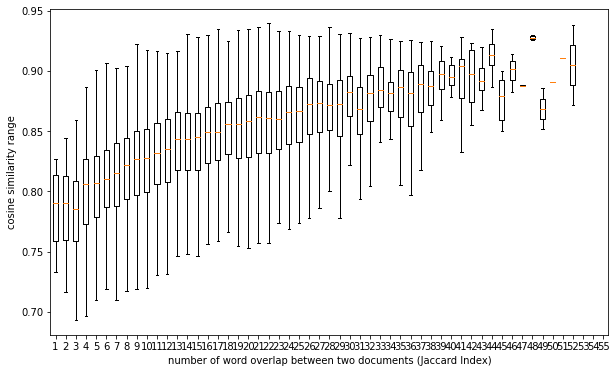

In [14]:
# final_vec = dict()
# doc_list = list(Embed_dict.keys())
# for doc_1 in tqdm(Embed_dict.keys()):
#   for doc_2 in Embed_dict.keys():
#     if doc_1 != doc_2:
#       list_1 = list(Embed_dict[doc_1].keys())[1:-1]
#       list_2 = list(Embed_dict[doc_2].keys())[1:-1]
#       common_elements = len(set(list_1).intersection(set(list_2)))
#       sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
#       final_vec[(doc_1,doc_2)] = [common_elements, sim]



final_vec = dict()
doc_list = list(Embed_dict.keys())

for ind1 in tqdm(range(len(doc_list))):
  doc_1 = doc_list[ind1]
  for ind2 in range(ind1+1,len(doc_list)):
    doc_2 = doc_list[ind2]
    # print(doc_1, '   ',doc_2)
    list_1 = list(Embed_dict[doc_1].keys())[1:-1]
    list_2 = list(Embed_dict[doc_2].keys())[1:-1]
    common_elements = len(set(list_1).intersection(set(list_2)))
    sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
    final_vec[(doc_1,doc_2)] = [common_elements, sim]


# freq_dict = dict()
# for ele in final_vec.values():
freq = [val_ for val_ in  final_vec.values()]
min_ = 1000
max_ = 0
for el in freq:
  max_ = el[0] if el[0]>max_ else max_
  min_ = el[0] if el[0]<min_ else min_
freq_dic = dict()
for key_ in range(min_,max_):
  temp = list()
  for el in freq:
    if el[0] == key_:
      temp.append(el[1])
  freq_dic[key_] = temp
for key, val_ in freq_dic.items():
  print(key, '  -->  ', len(val_))


import matplotlib.pyplot as plt

res = [val_ for val_ in freq_dic.values()]

plt.figure(figsize=(10,6))
plt.boxplot(res,showfliers=False)
# plt.boxplot(res,showfliers=True)

plt.ylabel("cosine similarity range")
plt.xlabel("number of word overlap between two documents (Jaccard Index)")
plt.show()

100%|██████████| 200/200 [00:08<00:00, 23.39it/s]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


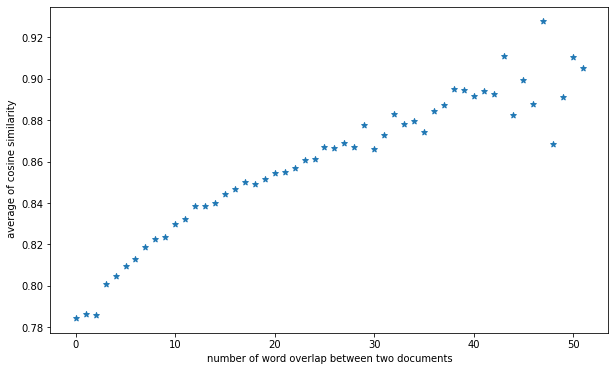

In [15]:
final_vec = dict()
doc_list = list(Embed_dict.keys())

for ind1 in tqdm(range(len(doc_list))):
  doc_1 = doc_list[ind1]
  for ind2 in range(ind1+1,len(doc_list)):
    doc_2 = doc_list[ind2]
    # print(doc_1, '   ',doc_2)
    list_1 = list(Embed_dict[doc_1].keys())[1:-1]
    list_2 = list(Embed_dict[doc_2].keys())[1:-1]
    common_elements = len(set(list_1).intersection(set(list_2)))
    sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
    final_vec[(doc_1,doc_2)] = [common_elements, sim]


# freq_dict = dict()
# for ele in final_vec.values():
freq = [val_ for val_ in  final_vec.values()]
min_ = 1000
max_ = 0
for el in freq:
  max_ = el[0] if el[0]>max_ else max_
  min_ = el[0] if el[0]<min_ else min_
freq_dic = dict()
for key_ in range(min_,max_):
  temp = list()
  for el in freq:
    if el[0] == key_:
      temp.append(el[1])
  freq_dic[key_] = np.average(temp)
# for key, val_ in freq_dic.items():
#   print(key, '  -->  ', len(val_))


import matplotlib.pyplot as plt

res = [val_ for val_ in freq_dic.values()]
x = [ind for ind in range(len(res))]

plt.figure(figsize=(10,6))
plt.scatter(x, res, marker ="*",)
# plt.boxplot(res,showfliers=True)

plt.ylabel(" average of cosine similarity")
plt.xlabel("number of word overlap between two documents")
plt.show()

100%|██████████| 200/200 [00:08<00:00, 23.29it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


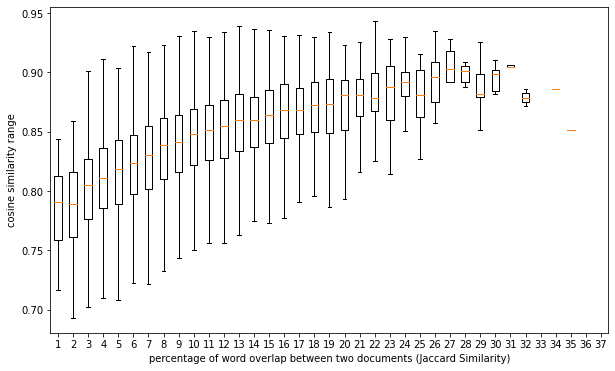

In [16]:
final_vec = dict()
doc_list = list(Embed_dict.keys())

for ind1 in tqdm(range(len(doc_list))):
  doc_1 = doc_list[ind1]
  for ind2 in range(ind1+1,len(doc_list)):
    doc_2 = doc_list[ind2]
    # print(doc_1, '   ',doc_2)
    list_1 = list(Embed_dict[doc_1].keys())[1:-1]
    list_2 = list(Embed_dict[doc_2].keys())[1:-1]
    common_elements = 2*len(set(list_1).intersection(set(list_2))) / (len(set(list_1).union(set(list_2))))
    sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
    final_vec[(doc_1,doc_2)] = [int(100*common_elements), sim]


# freq_dict = dict()
# for ele in final_vec.values():
freq = [val_ for val_ in  final_vec.values()]
min_ = 1000
max_ = 0
for el in freq:
  max_ = el[0] if el[0]>max_ else max_
  min_ = el[0] if el[0]<min_ else min_
freq_dic = dict()
for key_ in range(min_,max_):
  temp = list()
  for el in freq:
    if el[0] == key_:
      temp.append(el[1])
  freq_dic[key_] = temp


import matplotlib.pyplot as plt

res = [val_ for val_ in freq_dic.values()]

plt.figure(figsize=(10,6))
plt.boxplot(res,showfliers=False)
# plt.boxplot(res,showfliers=True)

plt.ylabel("cosine similarity range")
plt.xlabel("percentage of word overlap between two documents (Jaccard Similarity)")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


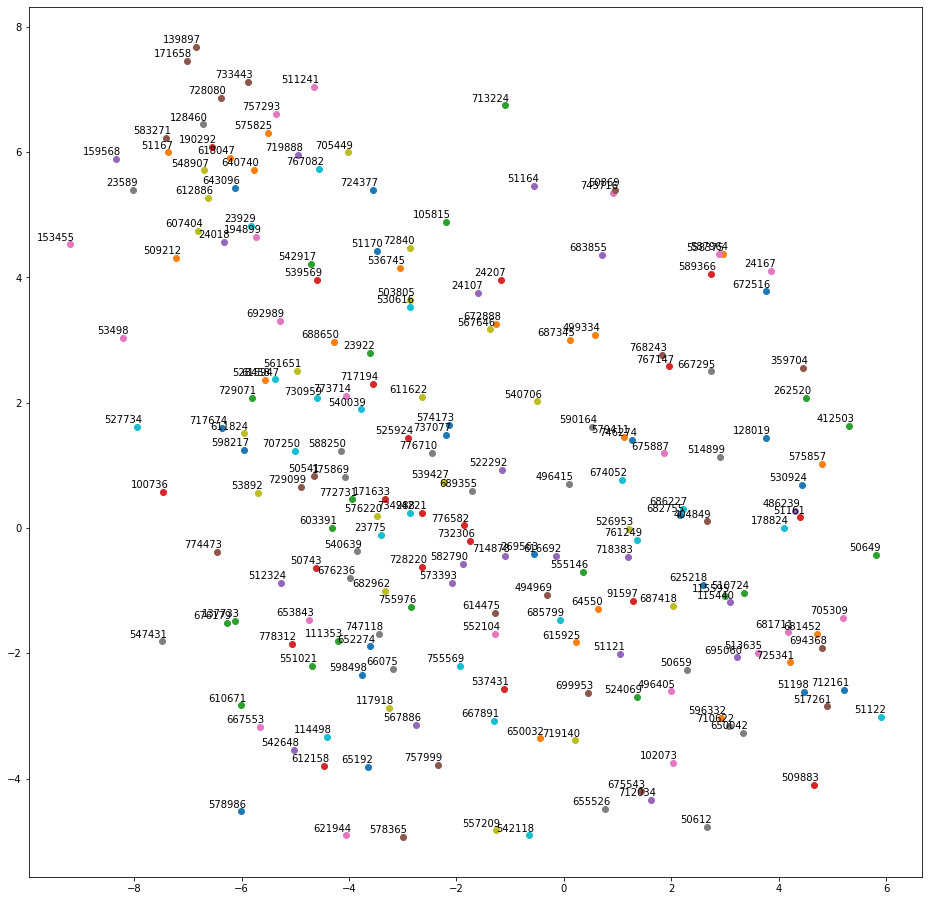

In [17]:
from sklearn.manifold import TSNE

cls_list = dict()
for key_, val_  in Embed_dict.items():
  cls_list[key_] = list(np.array(val_['cls']))

# tsne_plot(cls_list.keys(), cls_list.values())

labels = list(cls_list.keys())
tokens = list(cls_list.values())

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.show()

In [18]:
# vec1 = Embed_dict[91615]['cls']
# vec2 = Embed_dict[232083]['cls']
# print(cosine_similarity([vec1], [vec2])[0][0])

# vec1 = Embed_dict[776582]['cls']
# vec2 = Embed_dict[690145]['cls']
# print(cosine_similarity([np.array(vec1)], [np.array(vec2)])[0][0])
# print(cosine_similarity([np.array(vec2)], [np.array(vec1)])[0][0])

In [19]:
# import scipy
# cosine = scipy.spatial.distance.cosine(vec1, vec2)


# vec1 = Embed_dict[91615]['cls']
# vec2 = Embed_dict[232083]['cls']
# cosine = scipy.spatial.distance.cosine(vec1, vec2)
# print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')

# vec1 = Embed_dict[776582]['cls']
# vec2 = Embed_dict[690145]['cls']
# cosine = scipy.spatial.distance.cosine(vec1, vec2)
# print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')


In [20]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}
for id_, content_ in tqdm(zip(df['id'],df['content'])):
  tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
  tmp_d = tokenizer.tokenize(content_)
  temp_dict = dict()
  temp_dict['cls'] = tmp_e[0]
  for emb, tok in zip(tmp_e[1:-1], tmp_d):
    temp_dict[tok] = emb
  temp_dict['sep'] = tmp_e[-1]
  Embed_dict[id_] = temp_dict


200it [00:44,  4.47it/s]


100%|██████████| 200/200 [00:07<00:00, 25.04it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


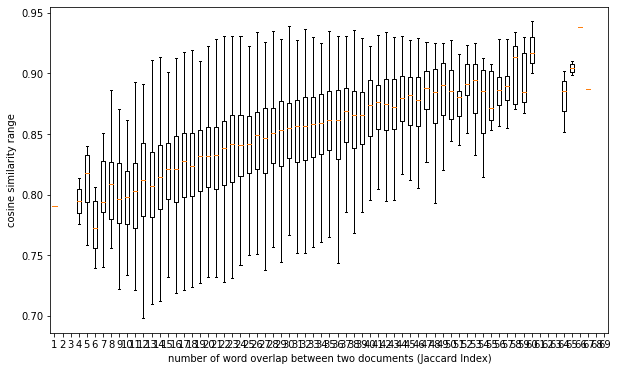

100%|██████████| 200/200 [00:09<00:00, 22.10it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


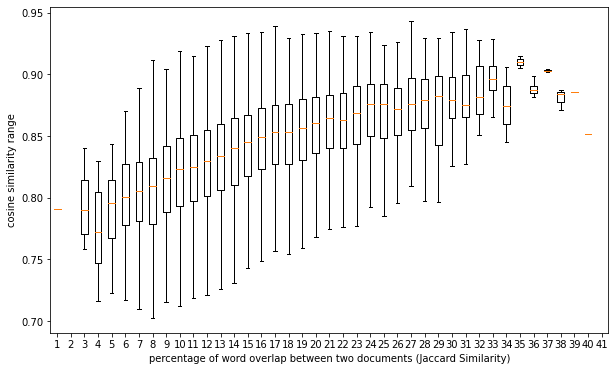

In [21]:
final_vec = dict()
doc_list = list(Embed_dict.keys())

for ind1 in tqdm(range(len(doc_list))):
  doc_1 = doc_list[ind1]
  for ind2 in range(ind1+1,len(doc_list)):
    doc_2 = doc_list[ind2]
    # print(doc_1, '   ',doc_2)
    list_1 = list(Embed_dict[doc_1].keys())[1:-1]
    list_2 = list(Embed_dict[doc_2].keys())[1:-1]
    common_elements = len(set(list_1).intersection(set(list_2)))
    sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
    final_vec[(doc_1,doc_2)] = [common_elements, sim]


# freq_dict = dict()
# for ele in final_vec.values():
freq = [val_ for val_ in  final_vec.values()]
min_ = 1000
max_ = 0
for el in freq:
  max_ = el[0] if el[0]>max_ else max_
  min_ = el[0] if el[0]<min_ else min_
freq_dic = dict()
for key_ in range(min_,max_):
  temp = list()
  for el in freq:
    if el[0] == key_:
      temp.append(el[1])
  freq_dic[key_] = temp
# for key, val_ in freq_dic.items():
#   print(key, '  -->  ', len(val_))


import matplotlib.pyplot as plt

res = [val_ for val_ in freq_dic.values()]

plt.figure(figsize=(10,6))
plt.boxplot(res,showfliers=False)
# plt.boxplot(res,showfliers=True)

plt.ylabel("cosine similarity range")
plt.xlabel("number of word overlap between two documents (Jaccard Index)")
plt.show()




final_vec = dict()
doc_list = list(Embed_dict.keys())

for ind1 in tqdm(range(len(doc_list))):
  doc_1 = doc_list[ind1]
  for ind2 in range(ind1+1,len(doc_list)):
    doc_2 = doc_list[ind2]
    # print(doc_1, '   ',doc_2)
    list_1 = list(Embed_dict[doc_1].keys())[1:-1]
    list_2 = list(Embed_dict[doc_2].keys())[1:-1]
    common_elements = 2*len(set(list_1).intersection(set(list_2))) / (len(set(list_1).union(set(list_2))))
    sim = cosine_similarity([list(np.array(Embed_dict[doc_1]['cls']))], [list(np.array(Embed_dict[doc_2]['cls']))])[0][0]
    final_vec[(doc_1,doc_2)] = [int(100*common_elements), sim]


# freq_dict = dict()
# for ele in final_vec.values():
freq = [val_ for val_ in  final_vec.values()]
min_ = 1000
max_ = 0
for el in freq:
  max_ = el[0] if el[0]>max_ else max_
  min_ = el[0] if el[0]<min_ else min_
freq_dic = dict()
for key_ in range(min_,max_):
  temp = list()
  for el in freq:
    if el[0] == key_:
      temp.append(el[1])
  freq_dic[key_] = temp


import matplotlib.pyplot as plt

res = [val_ for val_ in freq_dic.values()]

plt.figure(figsize=(10,6))
plt.boxplot(res,showfliers=False)
# plt.boxplot(res,showfliers=True)

plt.ylabel("cosine similarity range")
plt.xlabel("percentage of word overlap between two documents (Jaccard Similarity)")
plt.show()